In [1]:
%load_ext autoreload
%autoreload 2
import datetime
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
from pprint import pprint

project_dir = os.sep.join([os.getcwd(), '..'])
#sys.path.append(os.sep.join([project_dir, 'src', 'processed']))
processed_data_dir = os.sep.join([project_dir, 'data', 'processed'])

%matplotlib inline

In [2]:
df = pd.read_feather(os.sep.join([processed_data_dir, 'obs_netflow.feather']))

In [3]:
display(df.head())

,DateTime,hour,weekday,month,public_holiday,school_holiday,temperature,wind_speed,humidity,sunshine,...,476,477,478,479,480,482,483,484,486,487
0,2016-04-01 07:00:00+00:00,9,4,4,0,0,2.7,1.4,46.0,60.0,...,0,0,0,0,0,0,0,0,0,0
1,2016-04-01 07:05:00+00:00,9,4,4,0,0,3.8,2.1,46.0,60.0,...,0,0,0,0,0,0,0,0,0,0
2,2016-04-01 07:10:00+00:00,9,4,4,0,0,3.8,2.1,46.0,60.0,...,0,0,0,0,0,0,0,0,0,0
3,2016-04-01 07:15:00+00:00,9,4,4,0,0,3.8,2.1,46.0,60.0,...,0,0,0,0,0,0,0,0,0,0
4,2016-04-01 07:20:00+00:00,9,4,4,0,0,3.8,2.1,46.0,60.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# No nan-values any more!
for v in df.columns:
    na = df[v].isna().sum()
    if na != 0:
        print(v, na)

In [5]:
cols = list(df.columns)
c_start = cols.index('157')
print(f'First station column: {c_start}')
print(f'Number of rows:       {len(df.index)}')
print(cols)

First station column: 19
Number of rows:       141253
['DateTime', 'hour', 'weekday', 'month', 'public_holiday', 'school_holiday', 'temperature', 'wind_speed', 'humidity', 'sunshine', 'precipitation', 'solar_elevation_angle', 'wind_direction_cat', 'weather_fair/cloudy', 'weather_fog/haze', 'weather_thunderstorm', 'weather_rain', 'weather_snow', 'weather_other', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249',

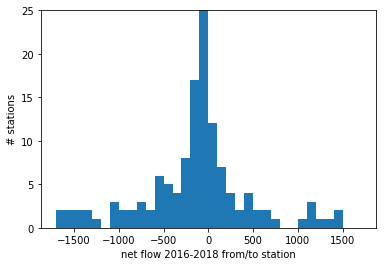

In [6]:
sum_over_time = df.iloc[:, c_start:].sum()
sum_over_time = sum_over_time[sum_over_time.ne(0)]
ax = sum_over_time.plot.hist(bins=range(-1700, 1701, 100))
ax.set_ylim(0, 25)
ax.set_xlabel('net flow 2016-2018 from/to station')
ax.set_ylabel('# stations')
fig = ax.get_figure()
fig.savefig('netflow.svg')

# Correlation

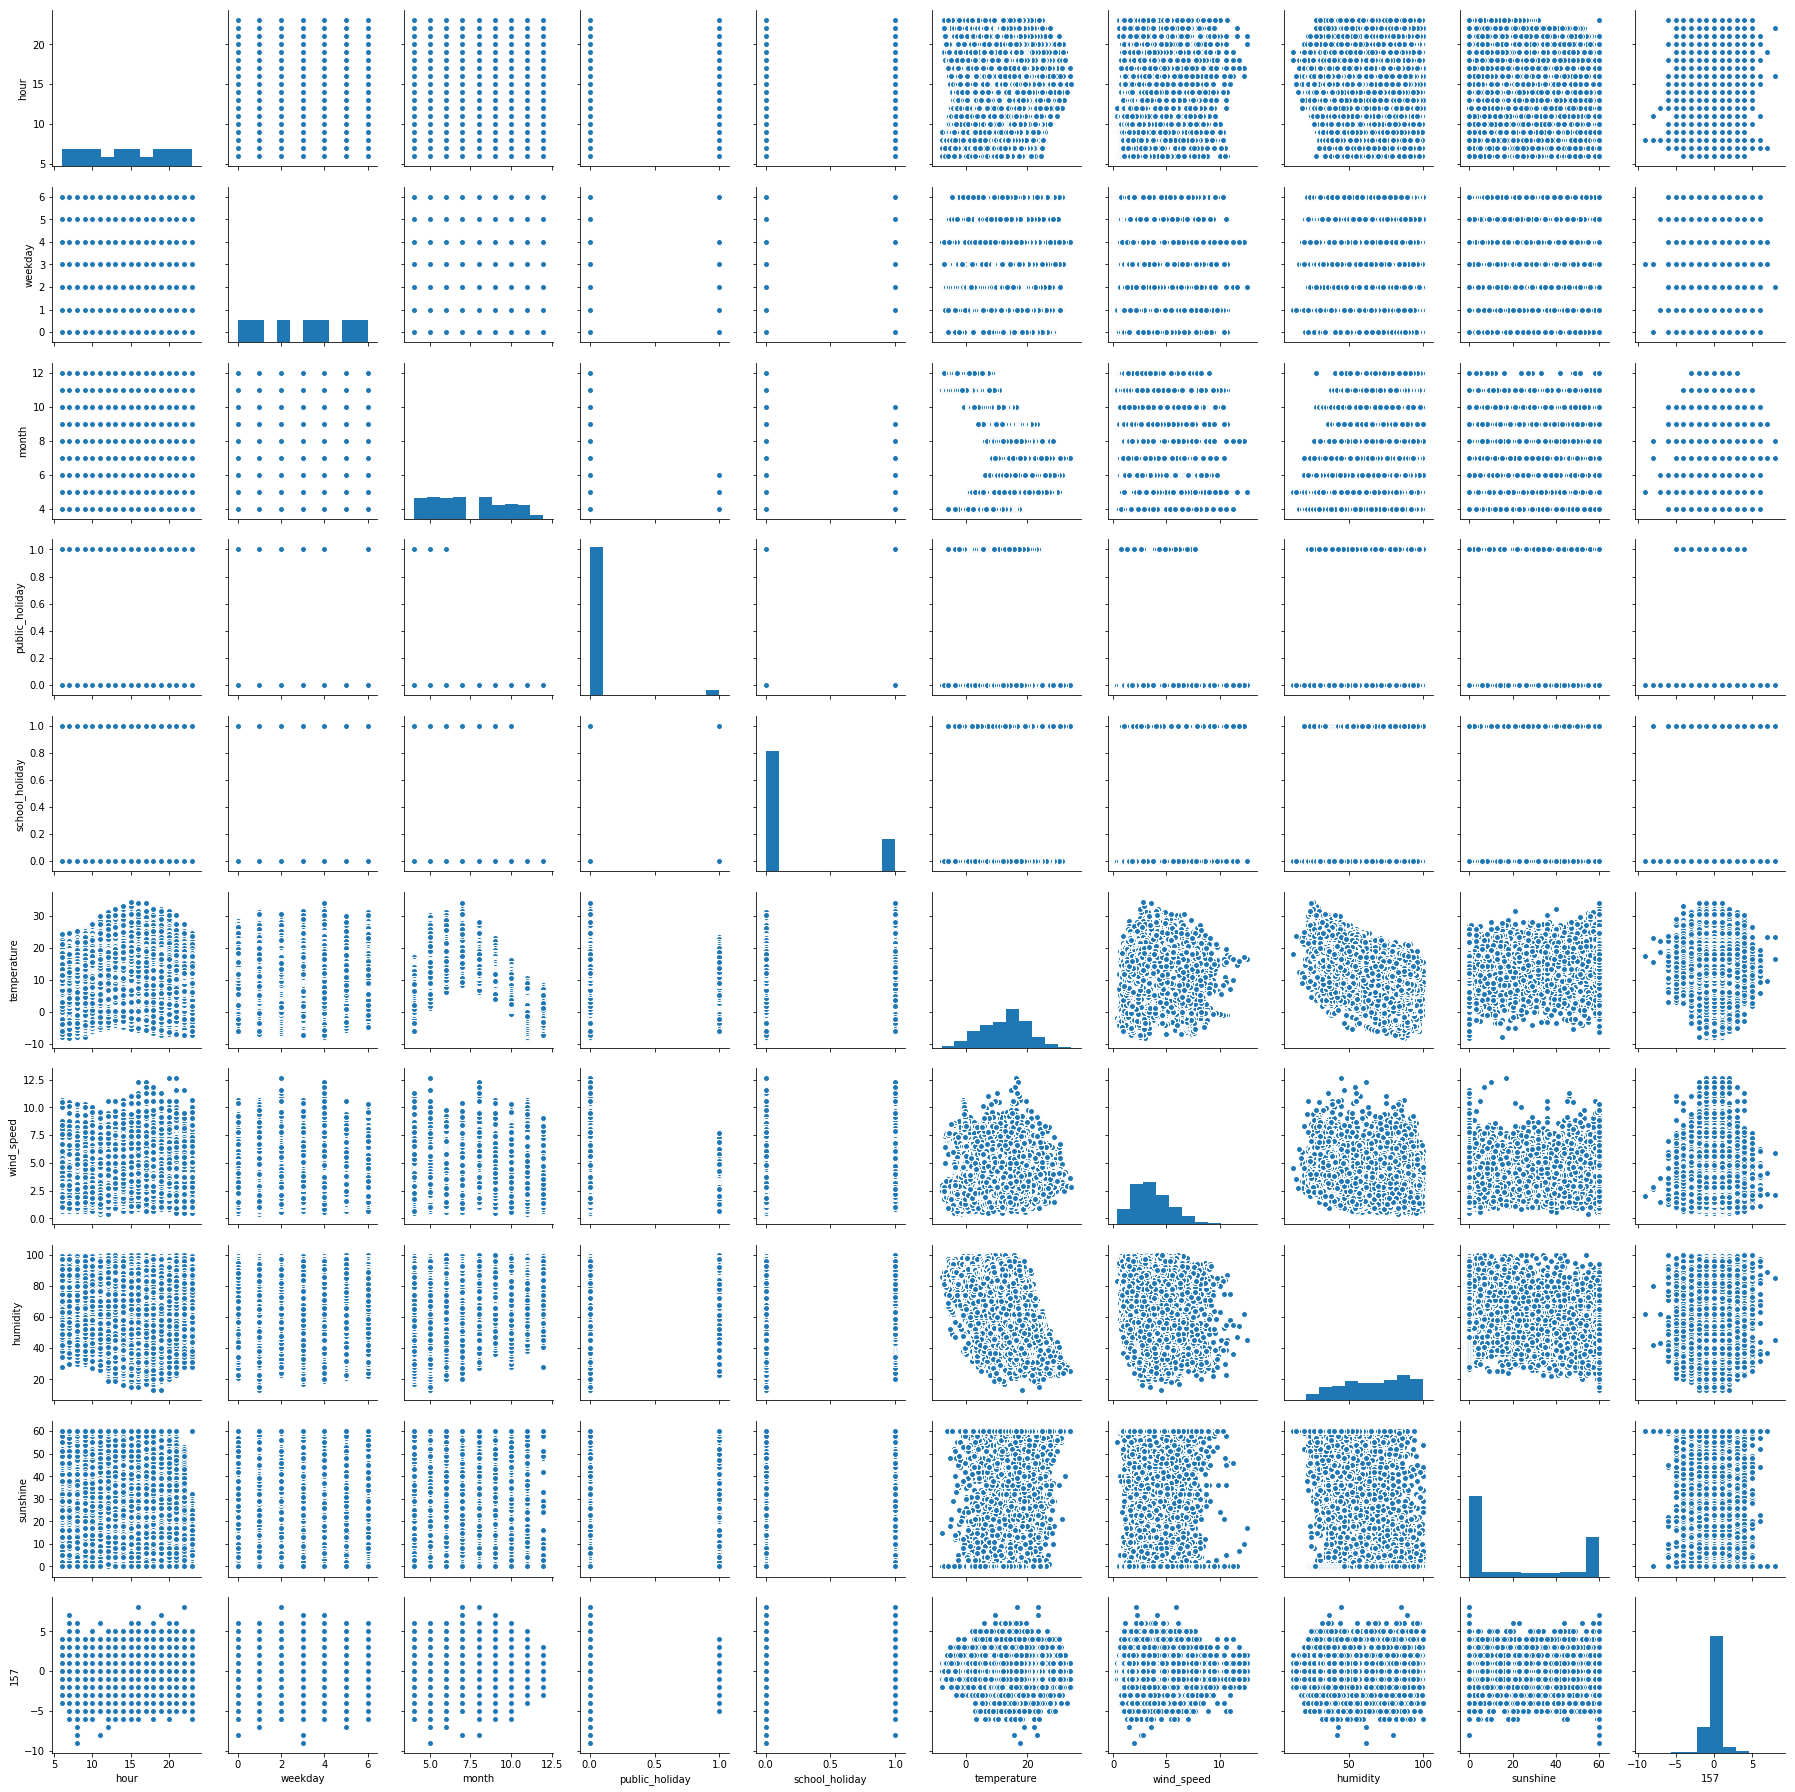

In [7]:
fig = sns.pairplot(df[['hour', 'weekday', 'month', 'public_holiday', 'school_holiday', 'temperature', 'wind_speed', 'humidity', 'sunshine', '157']])
fig.savefig('corr1.png')

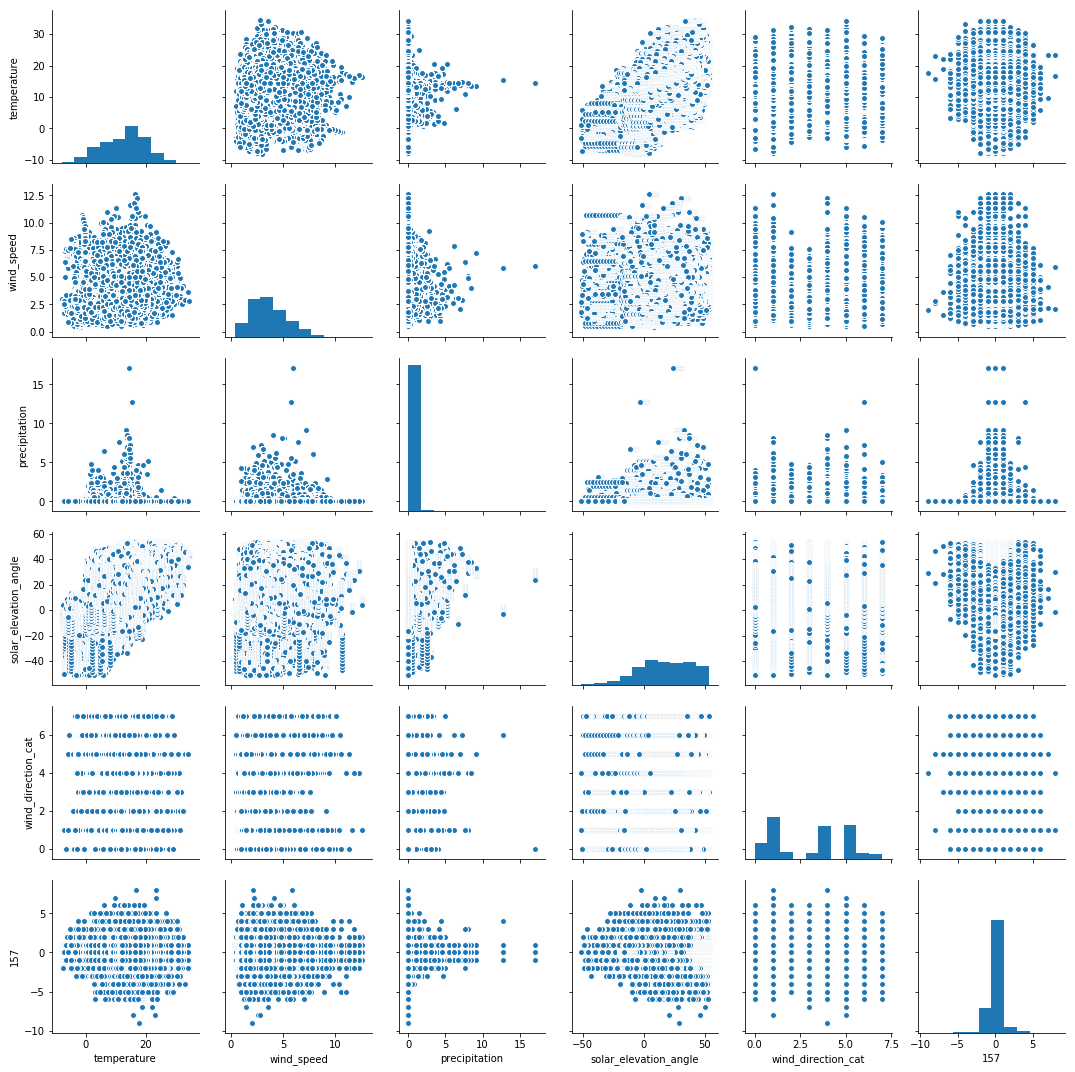

In [8]:
fig = sns.pairplot(df[['temperature', 'wind_speed', 'precipitation', 'solar_elevation_angle', 'wind_direction_cat', '157']])
fig.savefig('corr2.png')

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:19], df['157'], test_size=0.3, random_state=42)

In [11]:
regr = RandomForestRegressor(n_estimators= 16, random_state=42, n_jobs=-1)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [12]:
pprint(list(zip(df.columns[1:], regr.feature_importances_)))

[('hour', 0.04096429617989315),
 ('weekday', 0.0382253992183041),
 ('month', 0.022470839270633897),
 ('public_holiday', 0.002216772141436529),
 ('school_holiday', 0.008027810250326116),
 ('temperature', 0.09287552318090989),
 ('wind_speed', 0.08237858837752254),
 ('humidity', 0.07800479812965254),
 ('sunshine', 0.03528778475978114),
 ('precipitation', 0.005852687337843763),
 ('solar_elevation_angle', 0.5428188728868433),
 ('wind_direction_cat', 0.03486597559185977),
 ('weather_fair/cloudy', 0.002021001429232791),
 ('weather_fog/haze', 0.007162202292760218),
 ('weather_thunderstorm', 0.0005703391451794134),
 ('weather_rain', 0.005984908886050558),
 ('weather_snow', 0.0002576663080046586),
 ('weather_other', 1.4534613765646412e-05)]


In [13]:
y_pred = regr.predict(X_test)
print(mean_squared_error(y_test, y_pred))

1.0407621280323769


Is this good? Not really: the mean squared error is bigger than the standard deviation.

In [14]:
df['157'].describe()

count    141253.000000
mean          0.026930
std           0.930946
min          -9.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: 157, dtype: float64

Use same forest parameters as in fastai-notebook:

In [15]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [16]:
y_pred = m.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.9563198335089421


Slightly better than the above predictor -- which is to be expected with the higher complexity allowed here.

# Data exploration